# **Image Classification with NN vs CNN**
Compare the performance of a basic Neural Network (NN) and a Convolutional Neural Network (CNN) on the Fashion MNIST dataset.<br>

Submitted by: *Selim Ahmed*<br>
AI Engineering - Batch 1


## Import required library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow related
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

# tensorflow fashion dataset
from tensorflow.keras.datasets import fashion_mnist

# Best epochs number using EarlyStopping & ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## **Prepare Dataset**

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# For NN: Flattened input
x_train_nn = x_train.reshape(-1, 28 * 28)
x_test_nn = x_test.reshape(-1, 28 * 28)

# For CNN: Add channel dimension
x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

# Class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


## **Exploratory Data Analysis (EDA)**

### Initial Inspection

In [ ]:
print("--- Dataset Initial Inspection ---")
print(f"Training images shape -> {x_train.shape}")
print(f"Test images shape -> {x_test.shape}")
print(f"Image shape (single sample) -> {x_train[0].shape}")

print(f"\nData type of training images -> {x_train.dtype}")
print(f"Data type of training labels -> {y_train.dtype}")

print(f"\nMinimum pixel value in training images -> {np.min(x_train)}")
print(f"Maximum pixel value in training images -> {np.max(x_train)}")

--- Dataset Initial Inspection ---
Training images shape -> (60000, 28, 28)
Test images shape -> (10000, 28, 28)
Image shape (single sample) -> (28, 28)

Data type of training images -> float32
Data type of training labels -> uint8

Minimum pixel value in training images -> 0.0
Maximum pixel value in training images -> 1.0


### Pixel Value Distribution


Pixel Value Distribution (Before Normalization)
Min: 0.0, Max: 1.0, Mean: 0.29, Std: 0.35

After Normalization
Min: 0.0, Max: 0.003921568859368563, Mean: 0.00, Std: 0.00


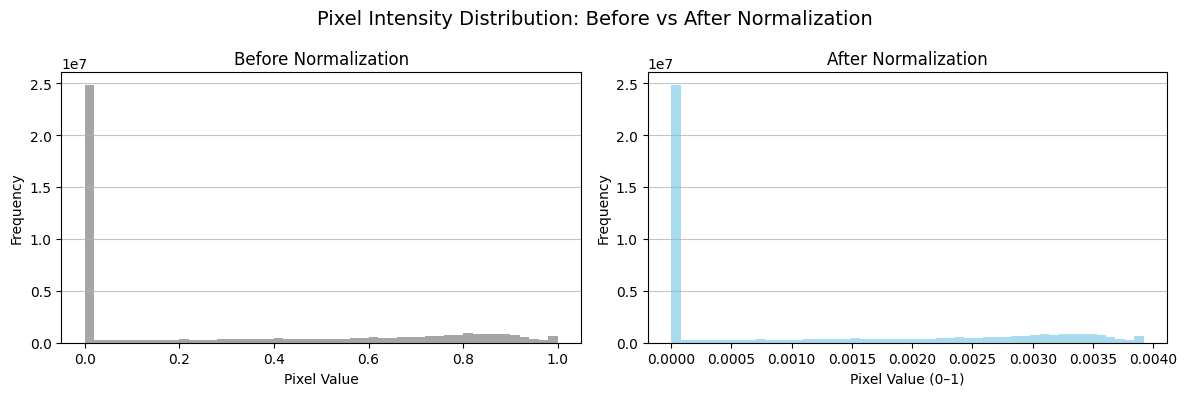

In [ ]:
# --- Before Normalization ---
print("\nPixel Value Distribution (Before Normalization)")
print(f"Min: {np.min(x_train)}, Max: {np.max(x_train)}, Mean: {np.mean(x_train):.2f}, Std: {np.std(x_train):.2f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(x_train.flatten(), bins=50, color='gray', alpha=0.7)
plt.title('Before Normalization')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# --- After Normalization ---
x_train_norm = x_train / 255.0
print("\nAfter Normalization")
print(f"Min: {np.min(x_train_norm)}, Max: {np.max(x_train_norm)}, Mean: {np.mean(x_train_norm):.2f}, Std: {np.std(x_train_norm):.2f}")

plt.subplot(1, 2, 2)
plt.hist(x_train_norm.flatten(), bins=50, color='skyblue', alpha=0.7)
plt.title('After Normalization')
plt.xlabel('Pixel Value (0–1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.suptitle("Pixel Intensity Distribution: Before vs After Normalization", fontsize=14)
plt.tight_layout()
plt.show()

### Image Visualization

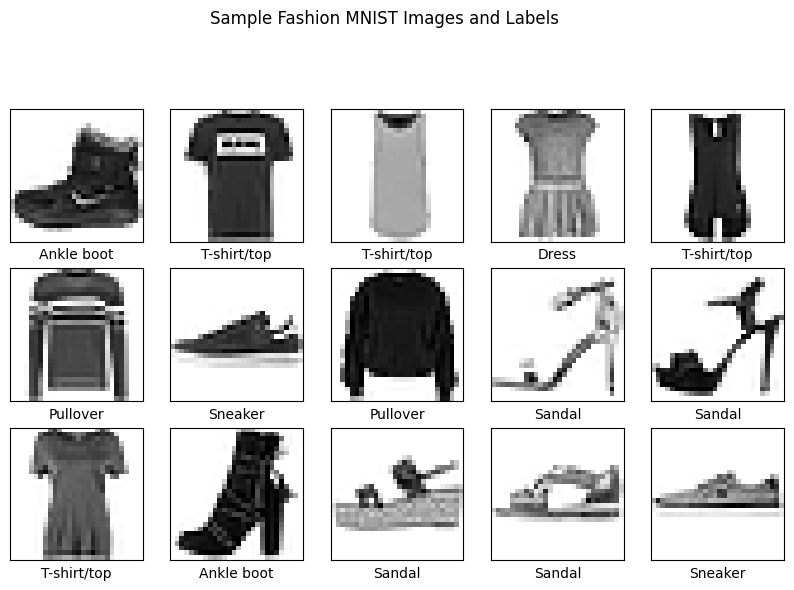

In [ ]:
# Define class names (if not already defined)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 10))
for i in range(15): # Display 25 random images
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary) # Use original x_train for visualization
    plt.xlabel(class_names[y_train[i]])
plt.suptitle('Sample Fashion MNIST Images and Labels')
plt.show()

### Class Distribution

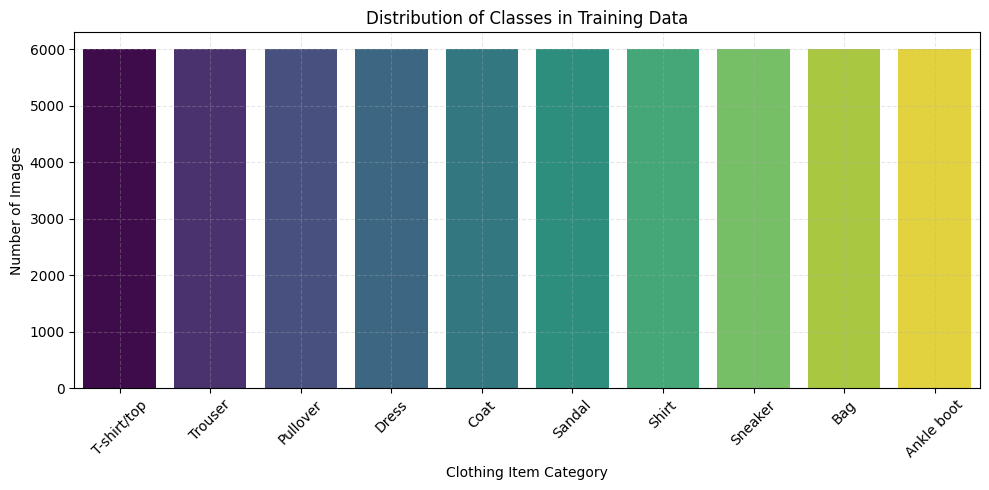


Class distribution (Training & Test):
0. T-shirt/top image count -> Training: 6000 & Test: 1000
1. Trouser image count -> Training: 6000 & Test: 1000
2. Pullover image count -> Training: 6000 & Test: 1000
3. Dress image count -> Training: 6000 & Test: 1000
4. Coat image count -> Training: 6000 & Test: 1000
5. Sandal image count -> Training: 6000 & Test: 1000
6. Shirt image count -> Training: 6000 & Test: 1000
7. Sneaker image count -> Training: 6000 & Test: 1000
8. Bag image count -> Training: 6000 & Test: 1000
9. Ankle boot image count -> Training: 6000 & Test: 1000


In [ ]:
# Count occurrences of each label in the training set
unique_labels, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique_labels, counts))

# Count occurrences of each label in the test set (optional, but good practice)
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
label_counts_test = dict(zip(unique_labels_test, counts_test))


# Countplot of Training Data
df = pd.DataFrame({'label': y_train})
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df, palette='viridis', hue='label', legend=False)
plt.title("Distribution of Classes in Training Data")
plt.xlabel("Clothing Item Category")
plt.ylabel("Number of Images")
plt.xticks(ticks=range(10), labels=class_names, rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Print combined distribution
print("\nClass distribution (Training & Test):")
for label in sorted(label_counts.keys()):
    train_count = label_counts.get(label, 0)
    test_count = label_counts_test.get(label, 0)
    print(f"{label}. {class_names[label]} image count -> Training: {train_count} & Test: {test_count}")


## **Build Models**

### Neural Network (NN)

In [ ]:
print("--- Building and Training Neural Network (NN) with Callbacks ---")
nn_model = Sequential([
    Input(shape=(784,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(10, activation='softmax')
])

nn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

print("\nNN Model Architecture:")
nn_model.summary()

# --- Start: Callbacks ---
early_stopping_nn = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_filepath_nn = 'best_nn_model.keras'

model_checkpoint_nn = ModelCheckpoint(
    filepath=checkpoint_filepath_nn,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1)
# --- End: Callbacks ---

print("\nTraining NN Model with EarlyStopping and ModelCheckpoint...")
nn_history = nn_model.fit(
    x_train_nn, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping_nn, model_checkpoint_nn, lr_scheduler],
    verbose=2
)

print("\nNN Model training complete.")
nn_model.load_weights(checkpoint_filepath_nn)

--- Building and Training Neural Network (NN) with Callbacks ---

NN Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,298 (954.29 KB)

 Trainable params: 243,530 (951.29 KB)

 Non-trainable params: 768 (3.00 KB)


Training NN Model with EarlyStopping and ModelCheckpoint...
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.81983, saving model to best_nn_model.keras
750/750 - 8s - 11ms/step - accuracy: 0.7743 - loss: 0.6559 - val_accuracy: 0.8198 - val_loss: 0.4878 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_accuracy improved from 0.81983 to 0.84292, saving model to best_nn_model.keras
750/750 - 10s - 13ms/step - accuracy: 0.8264 - loss: 0.4873 - val_accuracy: 0.8429 - val_loss: 0.4137 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_accuracy improved from 0.84292 to 0.85842, saving model to best_nn_model.keras
750/750 - 10s - 14ms/step - accuracy: 0.8374 - loss: 0.4556 - val_accuracy: 0.8584 - val_loss: 0.3832 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.85842
750/750 - 10s - 14ms/step - accuracy: 0.8480 - loss: 0.4301 - val_accuracy: 0.8531 - val_loss: 0.3919 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_accuracy improved from 

### Convolutional Neural Network (CNN)

In [ ]:
print("--- Building and Training Convolutional Neural Network (CNN) with Callbacks ---")

cnn_model = Sequential([
    Input(shape=(28, 28, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])


cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("\nCNN Model Architecture:")
cnn_model.summary()

# --- Start: Callbacks ---
early_stopping_cnn = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_filepath_cnn = 'best_cnn_model.keras'
model_checkpoint_cnn = ModelCheckpoint(
    filepath=checkpoint_filepath_cnn,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# --- End: Callbacks ---

print("\nTraining CNN Model with EarlyStopping and ModelCheckpoint...")
cnn_history = cnn_model.fit(
    x_train_cnn, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_test_cnn, y_test),
    callbacks=[early_stopping_cnn, model_checkpoint_cnn],
    verbose=2
)

print("\nCNN Model training complete.")
cnn_model.load_weights(checkpoint_filepath_cnn)

--- Building and Training Convolutional Neural Network (CNN) with Callbacks ---

CNN Model Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,442 (947.04 KB)

 Trainable params: 241,994 (945.29 KB)

 Non-trainable params: 448 (1.75 KB)


Training CNN Model with EarlyStopping and ModelCheckpoint...
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.84470, saving model to best_cnn_model.keras
938/938 - 145s - 154ms/step - accuracy: 0.7805 - loss: 0.6127 - val_accuracy: 0.8447 - val_loss: 0.4226
Epoch 2/50

Epoch 2: val_accuracy improved from 0.84470 to 0.86070, saving model to best_cnn_model.keras
938/938 - 141s - 150ms/step - accuracy: 0.8565 - loss: 0.3906 - val_accuracy: 0.8607 - val_loss: 0.3621
Epoch 3/50

Epoch 3: val_accuracy improved from 0.86070 to 0.89570, saving model to best_cnn_model.keras
938/938 - 146s - 156ms/step - accuracy: 0.8747 - loss: 0.3418 - val_accuracy: 0.8957 - val_loss: 0.2855
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.89570
938/938 - 198s - 211ms/step - accuracy: 0.8850 - loss: 0.3133 - val_accuracy: 0.8953 - val_loss: 0.2941
Epoch 5/50

Epoch 5: val_accuracy improved from 0.89570 to 0.89780, saving model to best_cnn_model.keras
938/938 - 140s - 149ms/step - accuracy: 0.

## **Evaluate and Compare Performance**




In [ ]:
# Evaluate models on the test set with restored best weights
nn_test_loss, nn_test_acc = nn_model.evaluate(x_test_nn, y_test, verbose=0)
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)

# Print comparison table
print("\nFinal Model Evaluation on Test Set")
print(f"{'Model':<10} {'Loss':>10} {'Accuracy':>12}")
print(f"{'-'*34}")
print(f"{'NN':<10} {nn_test_loss:>10.4f} {nn_test_acc:>12.4f}")
print(f"{'CNN':<10} {cnn_test_loss:>10.4f} {cnn_test_acc:>12.4f}")



Final Model Evaluation on Test Set
Model            Loss     Accuracy
----------------------------------
NN             0.3482       0.8762
CNN            0.2051       0.9284


## **Sample Predictions**

NN Sample Predictions:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


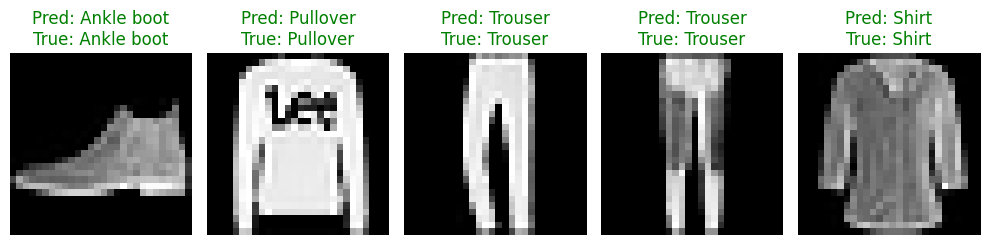




CNN Sample Predictions:
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


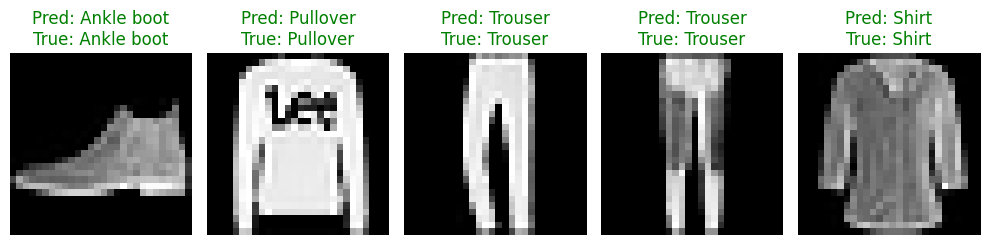

In [ ]:
def plot_sample_predictions(model, x_data, y_true, reshape=False):
    predictions = model.predict(x_data)
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = x_data[i].reshape(28,28) if reshape else x_data[i].reshape(28,28)
        plt.imshow(img, cmap='gray')
        pred_label = np.argmax(predictions[i])
        true_label = y_true[i]
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("NN Sample Predictions:")
plot_sample_predictions(nn_model, x_test_nn, y_test, reshape=True)

print("\n\n\nCNN Sample Predictions:")
plot_sample_predictions(cnn_model, x_test_cnn, y_test, reshape=True)


## **Plot Training History**


--- Plotting Training History ---


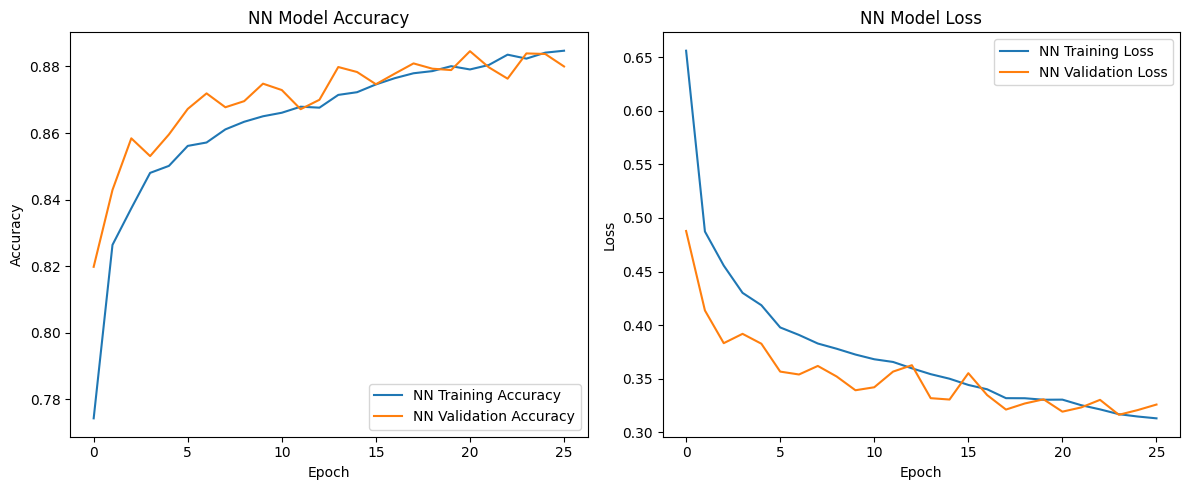

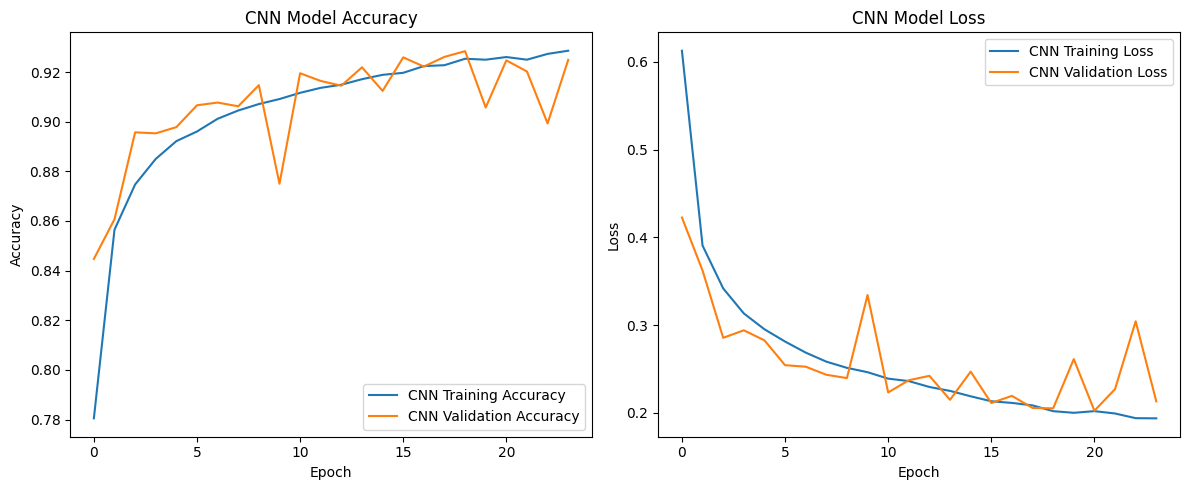


Project execution complete. The comparison and visualizations are displayed above.


In [ ]:
# (Optional) Plot training history (loss/accuracy)
print("\n--- Plotting Training History ---")

plt.figure(figsize=(12, 5))

# Plot NN training history
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['accuracy'], label='NN Training Accuracy')
plt.plot(nn_history.history['val_accuracy'], label='NN Validation Accuracy')
plt.title('NN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_history.history['loss'], label='NN Training Loss')
plt.plot(nn_history.history['val_loss'], label='NN Validation Loss')
plt.title('NN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot CNN training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nProject execution complete. The comparison and visualizations are displayed above.")

## Final Comparison

In [ ]:
print(f"--- Final Comparison ---")
print(f"NN Test Accuracy -> {nn_test_acc:.4f}")
print(f"CNN Test Accuracy -> {cnn_test_acc:.4f}")
print(f"Accuracy Different (CNN-NN) -> ", cnn_test_acc-nn_test_acc)
print(f"\nCNN performed better than NN by {((cnn_test_acc - nn_test_acc) * 100):.2f}% accuracy.")

--- Final Comparison ---
NN Test Accuracy -> 0.8762
CNN Test Accuracy -> 0.9284
Accuracy Different (CNN-NN) ->  0.05219995975494385

CNN performed better than NN by 5.22% accuracy.
